In [3]:
from ultralytics import YOLO
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import torch
import numpy as np
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
import os
from  detects import segany_mask_generate,yolo_mask_generate,vote_mask_generate,plot_sam_mask, pipeline
#sam = sam_model_registry["vit_h"](checkpoint="./segany/sam_vit_h_4b8939.pth")
sam = sam_model_registry["vit_l"](checkpoint="./segany/sam_vit_l_0b3195.pth").to("cuda")
sam_model_generator = SamAutomaticMaskGenerator(sam,
                                                pred_iou_thresh=0.7,
                                                stability_score_thresh=0.9,
                                                crop_n_points_downscale_factor=1,
                                                crop_n_layers=1)
yolo_model = YOLO('./yolo/last.pt')

id = 8
jpgorpng = ".png"

In [2]:
image = Image.open(f"./samples/sample{id}{jpgorpng}").convert("RGB")
yolo_masks = yolo_mask_generate(yolo_model,image)
sam_masks = segany_mask_generate(sam_model_generator,image)
voted_mask = vote_mask_generate(sam_masks,yolo_masks,threshold=0.8)


0: 640x448 1 person, 25.4ms
Speed: 4.5ms preprocess, 25.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


In [8]:
#根据mask生成最终的图片,保留透明通道
image_out = np.array(image.convert("RGBA"))
#RGBA转成BGRA
image_out = cv2.cvtColor(image_out, cv2.COLOR_RGBA2BGRA)
#如果是jpg图片，需要把它转换成png图片
#voted_mask取反
image_out[:,:,3] = (voted_mask)*255
#保存图片
cv2.imwrite(f"./samples/sample_masked{id}.png",image_out)
image_out[:,:,3] = (cv2.resize(yolo_masks,voted_mask.shape[::-1])) * 255
cv2.imwrite(f"./samples/sample_yolo_masked{id}.png",image_out)

True

In [4]:
path = r"D:\pyprojs\Anime-seg-yolov8\samples"
pipeline( sam_model_generator, yolo_model, path)

Processing 451.jpg:   0%|          | 0/2 [00:00<?, ?it/s]


D:\pyprojs\Anime-seg-yolov8\samples


0: 640x640 2 persons, 22.4ms
Speed: 2.2ms preprocess, 22.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Processing 451.jpg:   0%|          | 0/2 [00:13<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "d:\Anaconda\envs\CVproj\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\64930\AppData\Local\Temp\ipykernel_64820\3190383635.py", line 2, in <module>
    pipeline( sam_model_generator, yolo_model, path)
  File "d:\pyprojs\Anime-seg-yolov8\detects.py", line 87, in pipeline
NameError: name 'bboxes' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\Anaconda\envs\CVproj\lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "d:\Anaconda\envs\CVproj\lib\site-packages\IPython\core\ultratb.py", line 1310, in structured_traceback
    return FormattedTB.structured_traceback(
  File "d:\Anaconda\envs\CVproj\lib\site-packages\IPython\core\ultratb.py", line 1199, in structured_traceback
    retur

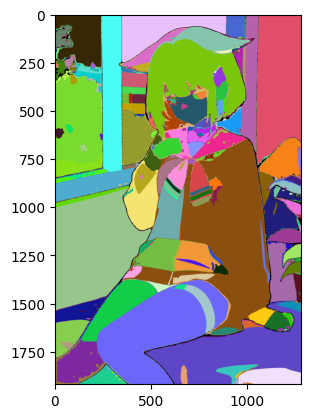

In [8]:
plt.imshow(plot_sam_mask(sam_masks))

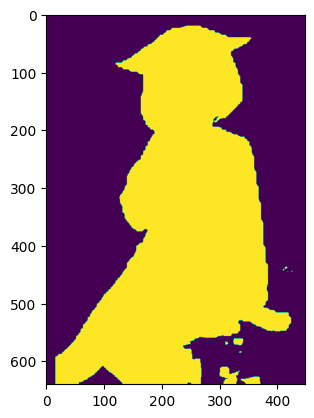

In [9]:
plt.imshow(yolo_masks)

In [9]:
image = Image.open("./samples/451.jpg").convert("RGB")
def yolo_mask_generate(yolo_model, image,expand_rate = 1.1):
    if isinstance(image, str):
        image = cv2.imread(image)
    if isinstance(image, Image.Image):
        image = np.array(image)
    # 生成mask
    masks = yolo_model(image)
    bboxes = masks[0].boxes.xyxyn.detach().cpu().numpy()
    masks = masks[0].masks.data.data.cpu().numpy().sum(axis=0)
    # 按照bboxes的大小，对mask进行裁剪
    bboxes = np.concatenate((bboxes.min(axis=0)[:2],bboxes.max(axis=0)[2:]))
    return masks[0].masks.data.data.cpu().numpy().sum(axis=0),bboxes
#yolo_mask_generate(yolo_model,image)
image = np.array(image)[:,:,::-1]
out = yolo_model(image)


0: 640x640 2 persons, 265.5ms
Speed: 5.0ms preprocess, 265.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [20]:
# 前两个取最小的 后两个取最大的
boxes = out[0].boxes.xyxyn.detach().cpu().numpy()
boxes_ = np.concatenate((boxes.min(axis=0)[:2],boxes.max(axis=0)[2:]))

In [5]:
image = Image.open("./samples/451.jpg").convert("RGB")
out = yolo_model(image)
boxes = out[0].boxes.xyxy.detach().cpu().numpy()


0: 640x640 2 persons, 255.5ms
Speed: 4.0ms preprocess, 255.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


In [6]:
boxes

array([[      27.44,      15.576,      320.12,      591.18],
       [     339.32,      13.705,      583.72,      590.74]], dtype=float32)